In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [20]:
%matplotlib inline
import numpy as np
from scipy import io as spio
import matplotlib.pyplot as plt
import pyuff
import tensorflow as tf
from tensorbeam.midprocess import DelayAndSum
from tensorbeam.postprocess import coherent_compounding
from tensorbeam.tools import data_path, download_from_url, plot

In [21]:
filename1 = "/home/emilbras/Beamforming/Carotid_1.uff"
filename2 = "/home/emilbras/Beamforming/Carotid_2.uff"
# matlab_lr_data = spio.loadmat('LRdataDone.mat')['LRdata']
channel_data = [pyuff.read_object(filename1, 'ch_data', False), pyuff.read_object(filename2, 'ch_data', False)]

In [22]:
channel_data[0].data = channel_data[0].data[:,:,:,:100]
channel_data[1].data = channel_data[1].data[:,:,:,:100]
print(channel_data[0].data.shape)
print(channel_data[1].data.shape)

(360, 192, 1, 100)
(360, 192, 1, 100)


In [23]:
print(channel_data[0].data.dtype)
print(channel_data[0].data.shape)

complex64
(360, 192, 1, 100)


In [24]:
N = 2
x_start = -( (channel_data[0].probe.N-1)/2 )*channel_data[0].probe.pitch
x_end = x_start + (channel_data[0].probe.N-1)*channel_data[0].probe.pitch

z_start = 0.005
z_end = 0.025
lambda_ = channel_data[0].sound_speed/channel_data[0].pulse.center_frequency
dx = dz = lambda_ / 2
bf_pars_x_axis = np.transpose(np.linspace(x_start, x_end, np.ceil(((x_end - x_start)/dx)/2)*2))
bf_pars_z_axis = np.transpose(np.linspace(z_start, z_end, np.ceil(((z_end - z_start)/dz)/2)*2))
X = np.stack(np.meshgrid(bf_pars_x_axis, bf_pars_z_axis, indexing='ij'),axis=-1).reshape(-1,2)
print(X.shape)
scan = pyuff.LinearScan()

c:\users\ebras\anaconda3\envs\tensorflowp35\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
c:\users\ebras\anaconda3\envs\tensorflowp35\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


(39128, 2)


In [25]:
tmp_channel_data = channel_data[0]

In [26]:
print(tmp_channel_data.pulse.center_frequency)
print(tmp_channel_data.PRF)
print(tmp_channel_data.sound_speed)
print(tmp_channel_data.modulation_frequency) # Bruk denne som f

5111350.5
6448.112
1540.0
5299377.5


In [27]:
tx_angles_t = []
for n in range (0, N):
    tx_angles_t.append(channel_data[n].sequence[0].source.azimuth)

tx_angles = np.array([tx_angles_t[0], tx_angles_t[0],
                      tx_angles_t[0], tx_angles_t[0],
                      tx_angles_t[0], tx_angles_t[1],
                      tx_angles_t[1], tx_angles_t[1],
                      tx_angles_t[1]])

rx_angles = np.array([-15, -3.5, 6, 15, 0, -6, 3.5, 15, 0]) /15*tx_angles_t[1]
tx_rx = []
tx_rx.append(np.array([-15, -3.5, 6, 15, 0])/15*tx_angles_t[1])
tx_rx.append(np.array([-6, 3.5, 15, 0])/15*tx_angles_t[1])
bf_ctr = 0

In [28]:
print(tx_angles)

[ 0.15757394  0.15757394  0.15757394  0.15757394  0.15757394 -0.15757394
 -0.15757394 -0.15757394 -0.15757394]


In [29]:
u_rx_angles = np.array([np.sin(rx_angles), -np.cos(rx_angles)])
u_tx_angles = np.array([np.sin(tx_angles), -np.cos(tx_angles)])

# 0 is x axis and 1 is z axis
angles = u_rx_angles + u_tx_angles
print(angles.shape)
sum_angles = angles[0] + angles[1]
theta = np.arctan2(angles[1],angles[0]) + (np.pi/2)
# a_magnitude = np.sqrt(((angles[0,:]**2) + (angles[1,:]**2)))
# theta = sum_angles/a_magnitude
# print(theta.shape)
print(theta)


(2, 9)
[ 1.57573941e-01  9.71705973e-02  4.72721831e-02  1.18607102e-09
  7.87869710e-02 -4.72721831e-02 -9.71705973e-02 -1.57573941e-01
 -7.87869710e-02]


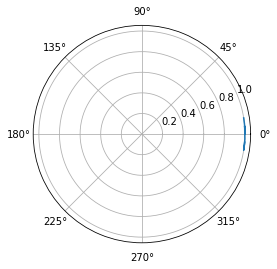

In [30]:
plt.subplot(projection='polar')
r = np.ones(theta.shape)
plt.plot(theta, r)


In [31]:
print(tx_rx[0].shape[0])
f_arr = np.zeros((9))
print(f_arr)
f_arr[:tx_rx[0].shape[0]] = np.where(tx_rx[0] == 0, 1.1, 1.4)
f_arr[tx_rx[0].shape[0]:tx_rx[0].shape[0]+tx_rx[1].shape[0]] = np.where(tx_rx[1] == 0, 1.1, 1.4)
print(f_arr.shape)
f_arr = np.expand_dims(f_arr, axis=1)
f_arr = np.tile(f_arr, 2).T
print(f_arr.shape)

5
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
(9,)
(2, 9)


In [32]:
lr_data = np.zeros((len(bf_pars_z_axis), len(bf_pars_x_axis),
                    tx_rx[0].size + tx_rx[1].size,
                    channel_data[0].data.shape[3]), dtype=np.complex128)



scan.x = X[...,0]
scan.y = 0*X[...,0]
scan.z = X[...,1]

for n in range(0, N):
    bf_vec = tx_rx[n]
    bmf = DelayAndSum()
    bmf.channel_data = channel_data[n]
    bmf.scan = scan

    for bn in range(0, bf_vec.size):
        print(bn)
        # TODO: Affine Transformation
        th = theta[int((5*n) + bn)]
        AT = np.array([[1, np.sin(th)], [0, 1]]).T
        t_X = X.dot(AT)
        scan.x = t_X[...,0]
        
        bmf.transmit_apodization.window = pyuff.Window.none  # tx_apodization -> transmit_apodization
        bmf.receive_apodization.tilt = bf_vec[bn]  # rx_apodization -> receive_apdization and change assignment value to scalar,
        if (bf_vec[bn] == 0):
            bmf.receive_apodization.window = pyuff.Window.tukey75  # rx_apodization -> receive_apodization
            bmf.receive_apodization.f_number = 1.1  # rx_apodization -> receive_apodization
        else:
            bmf.receive_apodization.window = pyuff.Window.tukey75  # rx_apodization -> receive_apodization
            bmf.receive_apodization.f_number = 1.4  # rx_apodization -> receive_apodization

        bmf.receive_apodization.focus = scan  # rx_apodization -> receive_apodization
        bmf._feed_dict = None  # hotfix
        b_data_multi = bmf.go()
        lr_data[:,:,bf_ctr,:] = np.reshape(b_data_multi, [len(bf_pars_z_axis), len(bf_pars_x_axis),channel_data[0].data.shape[3]], order='F')  # b_data_multi.data -> b_data_multi

        bf_ctr +=1

0
1
2
3
4
0
1
2
3


In [33]:
print("python.dtyppe = ", lr_data.dtype)
# print("matlab.dtype = ", matlab_lr_data.dtype)
# print("Matlab shape = ", matlab_lr_data.shape)
print("Python shape = ", lr_data.shape)
# print("Matlab mean = ", np.mean(np.abs(matlab_lr_data)))
print("Python mean = ", np.mean(np.abs(lr_data)))
# print("Difference = ", (np.abs(lr_data-matlab_lr_data) > 13).sum())

python.dtyppe =  complex128
Python shape =  (134, 292, 9, 100)
Python mean =  19377.809114581298


In [34]:
# plt.subplot(211)
# plt.imshow(10*np.log10(np.abs(max_angle_data[:,:,1])))

In [35]:
print(lr_data.shape)
pre_c_data = lr_data[:,:,rx_angles==0,:]
print(pre_c_data.shape)

comp_data = np.sum(pre_c_data, axis=2)
print(comp_data.shape)

# matlab_pre_c_data = matlab_lr_data[:,:,rx_angles==0,:]
# matlab_comp_data = np.sum(pre_c_data, axis=2)

(134, 292, 9, 100)
(134, 292, 2, 100)
(134, 292, 100)


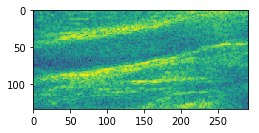

In [36]:
plt.subplot(211)
plt.imshow(10*np.log10(np.abs(comp_data[:,:,1])))

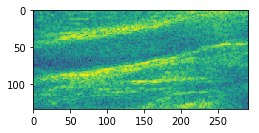

In [37]:
plt.subplot(211)
plt.imshow(10*np.log10(np.abs(comp_data[:,:,1])))
plt.show()

In [27]:
pre_min_angle_data = lr_data[:,:,7:8,:]
pre_max_angle_data = lr_data[:,:,0:1,:]
min_angle_data = np.sum(pre_min_angle_data, axis=2)
max_angle_data = np.sum(pre_max_angle_data, axis=2)

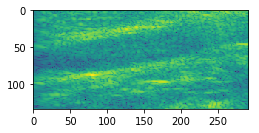

In [28]:
plt.subplot(211)
plt.imshow(10*np.log10(np.abs(min_angle_data[:,:,1])))

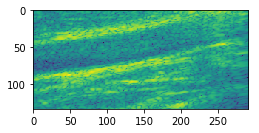

In [29]:
plt.subplot(211)
plt.imshow(10*np.log10(np.abs(max_angle_data[:,:,1])))

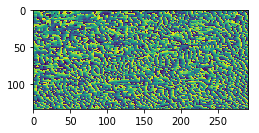

In [30]:
plt.subplot(211)
plt.imshow(np.angle(max_angle_data[:,:,1]))

In [ ]:
print(max_angle_data.shape)

In [ ]:
print(max_angle_data[0,0,0])
print(min_angle_data[0,0,0])

In [ ]:
import pickle

In [ ]:
# with open('lr_data.pkl', mode='wb') as f:
#     pickle.dump(lr_data,f)

In [ ]:
# with open('bfx.pkl', mode='wb') as f:
#     pickle.dump(bf_pars_x_axis,f)

In [ ]:
# with open('bfz.pkl', mode = )

In [ ]:
# print(obj.shape)
# print(lr_data.shape)

In [ ]:
R0 = np.nanmean(lr_data[...,0,:].conj()*lr_data[...,0,:],axis=-1)
plt.imshow(np.sqrt(R0.real))

In [ ]:
print(lr_data.shape)

In [ ]:
R1 = np.mean(lr_data[...,0,:-1].conj()*lr_data[...,0,1:],axis=-1)
a_r1 = np.angle(R1)
plt.imshow(a_r1,clim=(-np.pi, np.pi))

In [ ]:
plt.plot(lr_data[75, 150, 5, :].real.T, lr_data[75, 150, 5, :].imag.T)